Repeat of tests/tazotron/datasets/transforms/test_ct_necro_xray_pipeline.py using real CT/label files.
Uses seed=42 and renders XR before/after necrosis, then visualizes the diff.

In [1]:
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import torch
from diffdrr.visualization import plot_drr

from tazotron.datasets.ct import CTDataset
from tazotron.datasets.transforms.necro import AddRandomNecrosis
from tazotron.datasets.transforms.xray import RenderDRR


device = "cpu"

In [2]:
data_root = Path()

In [3]:
dataset = CTDataset(
    data_root,
    ct_name="ct.nii.gz",
    label_femoral_head_left="label_femoral_head_left.nii.gz",
    label_femoral_head_right="label_femoral_head_right.nii.gz",
)
if len(dataset) == 0:
    raise ValueError(f"No CT cases found in {data_root}")

seed = 42
intensity = 0.5

subject = dataset[0]
subject["rotations"] = torch.zeros((1, 3), dtype=torch.float32)
subject["translations"] = torch.tensor([[0.0, 800.0, 0.0]], dtype=torch.float32)

for key in ("volume", "density"):
    if key in subject:
        subject[key].set_data(subject[key].data.to(torch.float32))

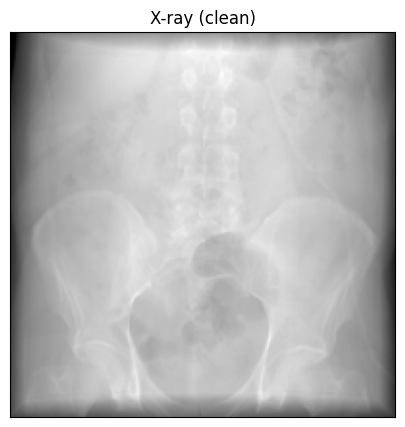

In [4]:
render = RenderDRR({"device": device})

subject_clean = copy.deepcopy(subject)
clean = render(subject_clean)
xray_clean = torch.nan_to_num(clean["xray"].detach().cpu())

plot_drr(xray_clean, ticks=False)
plt.title("X-ray (clean)")
plt.show()

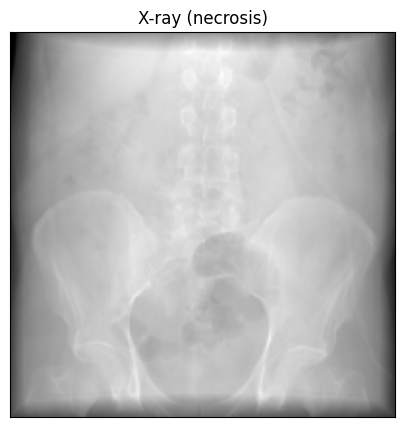

In [5]:
necro = AddRandomNecrosis(intensity=intensity, seed=seed)
subject_necro = copy.deepcopy(subject)
subject_necro = necro(subject_necro)
necro_rendered = render(subject_necro)
xray_necro = torch.nan_to_num(necro_rendered["xray"].detach().cpu())

plot_drr(xray_necro, ticks=False)
plt.title("X-ray (necrosis)")
plt.show()

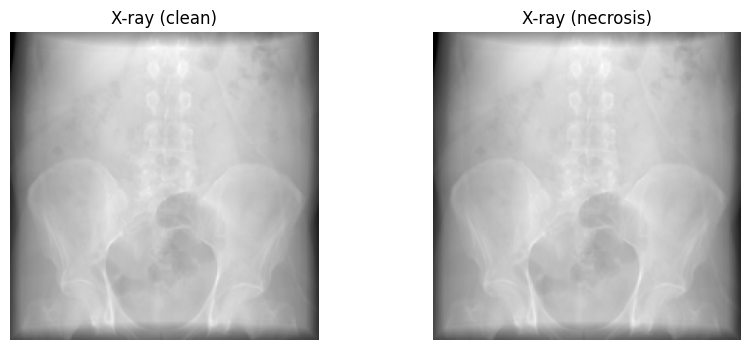

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(xray_clean[0, 0].cpu(), cmap="gray")
axes[0].set_title("X-ray (clean)")
axes[1].imshow(xray_necro[0, 0].cpu(), cmap="gray")
axes[1].set_title("X-ray (necrosis)")
for ax in axes:
    ax.axis("off")

Diff sum: 1027.6099


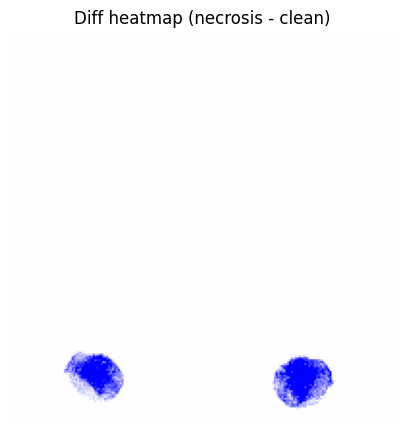

In [7]:
diff = (xray_necro - xray_clean).squeeze().cpu()
abs_diff = diff.abs()
vmax = float(torch.quantile(abs_diff, 0.99).item())
vmax = max(vmax, 1e-6)

plt.figure(figsize=(5, 5))
plt.imshow(diff, cmap="bwr", vmin=-vmax, vmax=vmax)
plt.title("Diff heatmap (necrosis - clean)")
plt.axis("off")

diff_sum = abs_diff.sum().item()
print(f"Diff sum: {diff_sum:.4f}")
assert diff_sum > 0, "Diff is zero: necrosis did not change the X-ray."